# Predict `Subject Age`

In [1]:
%matplotlib inline

In [2]:
##### Step 1: import functions #####
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation, Conv2D, AveragePooling2D, Input, Softmax, GlobalAveragePooling2D
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
import pickle
import pandas as pd
import numpy as np
from numpy.random import seed; seed(111)
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.random import set_seed; set_seed(111)
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import normalize
from six import StringIO  
from sklearn.tree import export_graphviz, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
from IPython.display import Image  
import pydotplus
import time
from pathlib import Path
import math

2021-09-02 15:12:28.460839: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-02 15:12:28.460906: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# %config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = [9,6]

In [4]:
#gpus = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(gpus[0], True)

In [5]:
phenotype = 'Subject Age'

In [6]:
#load data
aging_dir = Path('../')

with open(aging_dir/'aging-cytof-data.obj', 'rb') as f:
    allData = pickle.load(f)
samples = allData["samples"]
cyto_data = allData['expr_list']

# Truncate cytodata
cyto_data = cyto_data[ :, :10000]

markers = allData["marker_names"]

print(f'Dimensions of cyto_data: {cyto_data.shape}')
print(f'Dimensions of samples: {samples.shape}')
print(f'Names of the makers: {markers.values}')

Dimensions of cyto_data: (260, 10000, 27, 1)
Dimensions of samples: (260, 86)
Names of the makers: ['CELL_LENGTH' 'DEAD' 'CD19' 'CD4' 'CD8' 'IGD' 'CD85J' 'CD16' 'CD3' 'CD38'
 'CD27' 'CD14' 'CD94' 'CCR7' 'CD45RA' 'CD20' 'CD127' 'CD33' 'CD28' 'CD24'
 'CD161' 'TCRGD' 'CD56' 'HLADR' 'CD25' 'DNA1' 'DNA2']


<AxesSubplot:ylabel='Frequency'>

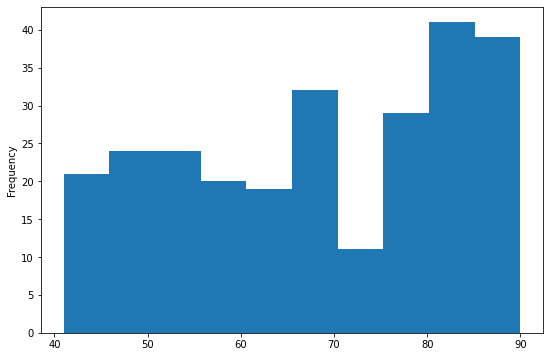

In [7]:
samples[phenotype].plot.hist()

Training Size: 160  Validation Size: 54


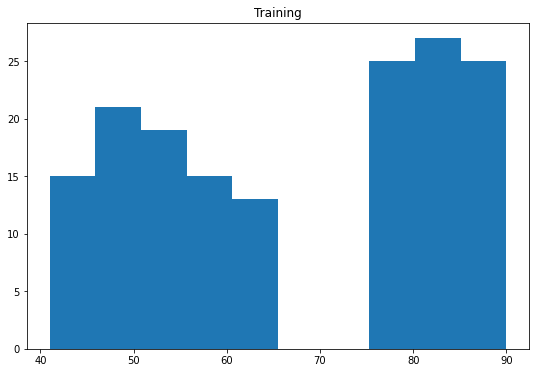

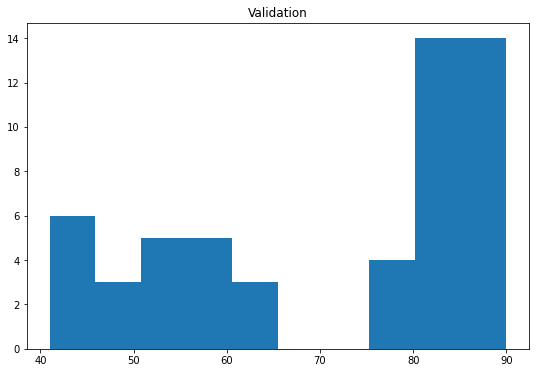

In [8]:
##### Step 3: split train, validation and test######
#normed_cyto = np.array(list(map(lambda x: (x-x.min(0))/x.ptp(0), cyto_data)))
x = []
y = []
for i, row in samples.iterrows():
    #Take out the center samples to create a bigger young/old distinction
    if math.isnan(row[phenotype]) or (row[phenotype] >= 65 and row[phenotype] <= 75):
        continue
    x.append(cyto_data[i][:10000])
  
    if row[phenotype] < 65:
        y.append(row[phenotype])
    else:
        y.append(row[phenotype])

age_range = max(y) - min(y)

#normalize cyto_data??

x = np.asarray(x)
y = np.asarray(y)

x_train, x_valid, y_train, y_valid = train_test_split(x, y, train_size=0.75)

print("Training Size: " + str(len(y_train)) + "  Validation Size: " + str(len(y_valid)))

plt.hist(y_train)
plt.title("Training") 
plt.show()

plt.hist(y_valid)
plt.title("Validation") 
plt.show()

#Turn the problem into a catagorical call - old = 1
for i in range(len(y_train)):
    if y_train[i] > 65:
        y_train[i] = 1
    else:
        y_train[i] = 0
               
for i in range(len(y_valid)):
    if y_valid[i] > 65:
        y_valid[i] = 1
    else:
        y_valid[i] = 0               
    

In [9]:
model = Sequential([
    Input(shape=x[0].shape),
    Conv2D(4, kernel_size = (1, x.shape[2]), activation=None),
    BatchNormalization(),
    Activation('relu'),
    #Conv2D(4, kernel_size = (1,1), activation=None),
    #BatchNormalization(),
    #Activation('relu'),
    GlobalAveragePooling2D(),
    #AveragePooling2D(pool_size = (x.shape[1], 1)),
    Flatten(),
    Dense(3, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dense(1, activation='sigmoid'),
])
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 10000, 1, 4)       112       
_________________________________________________________________
batch_normalization (BatchNo (None, 10000, 1, 4)       16        
_________________________________________________________________
activation (Activation)      (None, 10000, 1, 4)       0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 4)                 0         
_________________________________________________________________
flatten (Flatten)            (None, 4)                 0         
_________________________________________________________________
dense (Dense)                (None, 3)                 15        
_________________________________________________________________
batch_normalization_1 (Batch (None, 3)                 1

2021-09-02 15:12:44.779830: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-02 15:12:44.780031: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-02 15:12:44.780349: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-MN6AJ21): /proc/driver/nvidia/version does not exist
2021-09-02 15:12:44.781497: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
%%time
model_store = Path(f'Result/saved_weights_{phenotype}.hdf5')

# save the best performing model
checkpointer = ModelCheckpoint(filepath=model_store, 
                               monitor='accuracy', verbose=0, 
                               save_best_only=True)

st = time.time()
# model training
model.fit([x_train], y_train,
          batch_size=60,
          epochs=200, 
          verbose=1,
          callbacks=[checkpointer],
          validation_data=([x_valid], y_valid))
rt = time.time()-st

2021-09-02 15:12:45.224765: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
3/3 [==============================] - 1s 361ms/step - loss: 0.7403 - accuracy: 0.5562 - val_loss: 0.7480 - val_accuracy: 0.4074
Epoch 2/200
3/3 [==============================] - 0s 98ms/step - loss: 0.7123 - accuracy: 0.5938 - val_loss: 0.7413 - val_accuracy: 0.4074
Epoch 3/200
3/3 [==============================] - 0s 119ms/step - loss: 0.7069 - accuracy: 0.5562 - val_loss: 0.7348 - val_accuracy: 0.4074
Epoch 4/200
3/3 [==============================] - 0s 102ms/step - loss: 0.7013 - accuracy: 0.5750 - val_loss: 0.7291 - val_accuracy: 0.4074
Epoch 5/200
3/3 [==============================] - 0s 101ms/step - loss: 0.6791 - accuracy: 0.6000 - val_loss: 0.7238 - val_accuracy: 0.4074
Epoch 6/200
3/3 [==============================] - 0s 105ms/step - loss: 0.6676 - accuracy: 0.5875 - val_loss: 0.7192 - val_accuracy: 0.4074
Epoch 7/200
3/3 [==============================] - 0s 95ms/step - loss: 0.6592 - accuracy: 0.5813 - val_loss: 0.7146 - val_accuracy: 0.4074
Epoch 8/200
3/3

In [11]:
rt

110.66774892807007

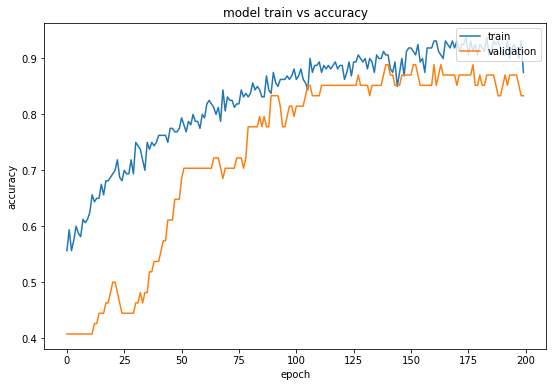

In [12]:
#####  Plot train and validation accuracy #####
history = model.history
plt.plot(pd.Series(history.history['accuracy']))
plt.plot(pd.Series(history.history['val_accuracy']))
plt.title('model train vs accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

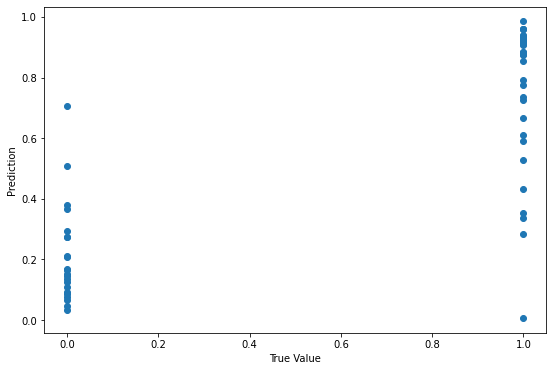

In [13]:
#### Test the final model #####
final_model = load_model(model_store)
x_test = x_valid
y_test = y_valid
y_scores = final_model.predict([x_test])
y_scores = y_scores.reshape(y_scores.shape[0])
plt.scatter(y_valid, y_scores)
plt.xlabel('True Value')
plt.ylabel('Prediction')
plt.show()


Accuracy: 0.8703703703703703



/tmp/ipykernel_4935/3410360083.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'Young', 'Old'])
/tmp/ipykernel_4935/3410360083.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', 'Young', 'Old'])


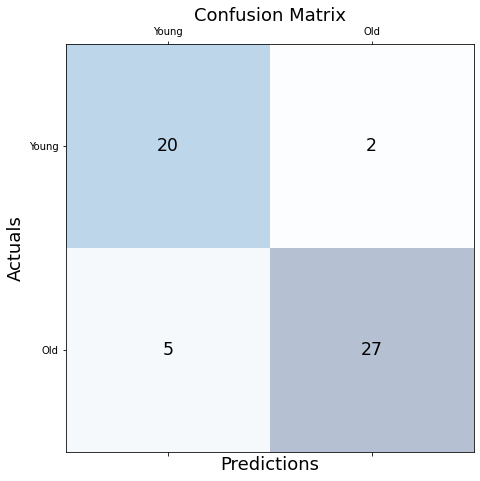

In [14]:
y_scores = np.rint(y_scores).astype(int)
cm = confusion_matrix(y_valid, y_scores)  

print ("")
print ("Accuracy: " + str((cm[0,0] + cm[1,1]) / sum(sum(cm))))
print ("")

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
ax.set_xticklabels(['', 'Young', 'Old'])
ax.set_yticklabels(['', 'Young', 'Old'])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

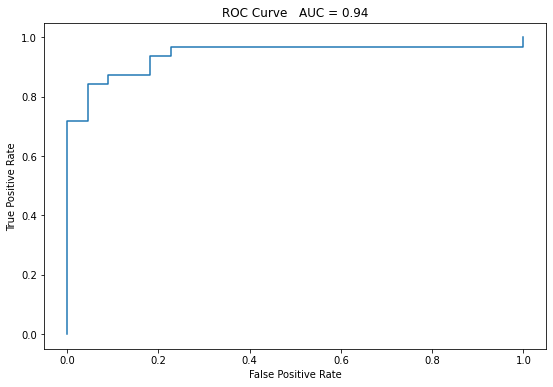

In [15]:
# generate ROC and AUC
y_scores = final_model.predict([x_test])
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.plot(fpr, tpr)
#plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve   AUC = {0:.2f}'.format(roc_auc))
plt.show()